# Necessary simplifications

## Overview

**Questions**
- Can I speed up MD?

**Objectives**
- Become familiar with the cut-off and periodic boundary condition as a method to speed up MD simulation
- Understand how to implement such simplifications in the MD

Molecular dynamics (MD) is a powerful simulation technique in it's own right. 
However, in order to apply MD to practical simulations (e.g. of **real** systems), some simplifications must be made.

## Cut-offs

If we plot the Lennard-Jones potential all the way out to 15 Å, it will look something like this.

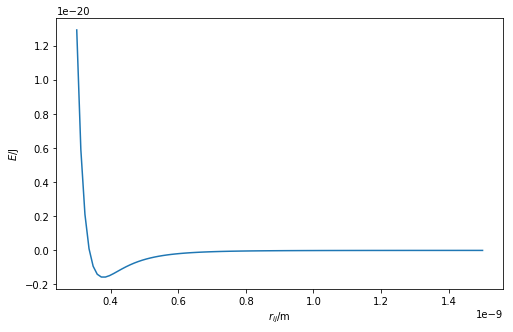

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def lj(rij, a, b):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the energy of the interaction.
    
    Parameters
    ----------
    rij: float
        Distance between two particles
    a: float 
        A parameter for interaction
    b: float 
        B parameter for interaction
    
    Returns
    -------
    float
        Energy of the interaction.
    """
    return a / np.power(rij, 12) - b / np.power(rij, 6)

r = np.linspace(3e-10, 15e-10, 100)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(r, lj(r, 1.363e-134, 9.273e-78))
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$E$/J')
plt.show()

It is clear that as the particles move further away from each other, their interaction energy tends towards zero. 
The concept of a cut-off suggests that if two particles are found to be very far apart, there is no need to calculate thh energy/force. 
Instead the value is simply taken as 0,

$$       E(r_{ij})=\left\{
  \begin{array}{@{}ll@{}}
    \dfrac{A}{r_{ij}^{12}} - \dfrac{B}{r_{ij}^6}, & \text{if}\ a<15\text{ Å} \\
    0, & \text{otherwise.}
  \end{array}\right.
$$

This saves significant computation time, as power relationships (e.g. power-12 or power-6) are vey computationally expensive to calculate. 

This code below shows a modification of the Lennard-Jones potential that accounts for this cut-off.

In [2]:
def lj(rij, a, b, force, cutoff):
    """
    Implementation of the Lennard-Jones potential 
    to calculate either the energy or the force
    which is considerate of the cut-off.
    
    Parameters
    ----------
    rij: float
        Distance between two particles
    a: float 
        A parameter for interaction
    b: float 
        B parameter for interaction
    force: bool
        If true the force will be determined
    cutoff: float
        The distance after which the interaction 
        is ignored
    
    Returns
    -------
    float
        Either the energy or the force of the interaction.
    """
    if rij < cutoff:
        if force:
            return 12 * a / np.power(rij, 13) - 6 * b / np.power(rij, 7)
        else:
            return a / np.power(rij, 12) - b / np.power(rij, 6)
    else:
        return 0

## Periodic boundary conditions

Even with cut-offs, it is still not straight-forward to design a large enough simulation cell to represent the bulk behaviour of liquids or solids in a physically realistic way. 
For example, what happens when the atoms interact with the walls of the cell? 
This is dealt with using **periodic boundary conditions**, these state that the cell being simulated is part of an infinite number of identical cells arranged in a lattice. 

<center>
    <br>
    <img src="../images/pbc.png" width="300px">
    <i>Figure 3. A two-dimensional example of a periodic cell.</i>
    <br>
</center>

When a particle reaches the cell wall it moves into the adjecent cell, and since all the cells are identical, it appears on the other side. 
The code below modifies the `update_pos` and `get_acceleration` functions from the previous lesson to account for the periodic boundary condition.

In [30]:
mass_of_argon = 39.948 # amu
mass_of_argon_kg = mass_of_argon * 1.6605e-27

def update_pos(x, v, a, dt, box_length):
    """
    Update the particle positions accounting for the 
    periodic boundary condition.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a single dimension
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension
    dt: float
        The timestep length
    box_length: float 
        The size of the periodic cell
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a single dimension
    """
    new_pos = np.zeros_like(x)
    for i in range(x.size):
        new_pos[i] = x[i] + v[i] * dt + 0.5 * a[i] * dt * dt
        new_pos[i] = new_pos[i] % box_length
    return new_pos

def get_accelerations(positions, box_length, cutoff):
    """
    Calculate the acceleration on each particle as a 
    result of each other particle. 
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, for all
        of the particles
    box_length: float 
        The size of the periodic cell
    cutoff: float
        The distance after which the interaction 
        is ignored
        
    Returns
    -------
    ndarray of floats
        The acceleration on each particle
    """
    rx = np.zeros((positions.size, positions.size))
    accelerationx = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size):
        for j in range(0, positions.size):
            if i != j:
                rx = positions[j] - positions[i]
                rmag = np.sqrt(rx * rx)
                rmag = rmag % box_length
                force = lj(rmag, 1.363e-134, 9.273e-78, True, cutoff)
                forcex = force * rx / rmag
                accelerationx[i, j] = forcex / mass_of_argon_kg
            else:
                accelerationx[i, j] = 0
    return np.sum(accelerationx, axis=0)

This means that we can use these new functions in our molecular dynamics simulation built previously. 
Note that it is common practice for very small boxes to use a cut off of half the simulation cell. 

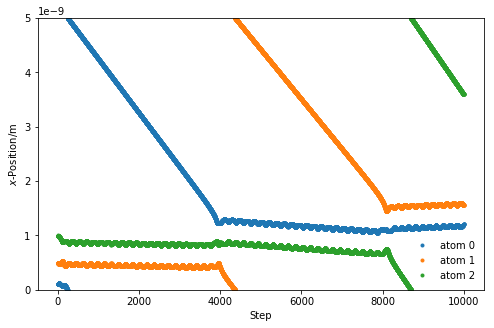

In [31]:
from scipy.constants import Boltzmann

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension 
        at the previous timestep
    a1: ndarray of floats
        The accelerations of the particles in a single dimension
        at the current timestep
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a single dimension
    """
    return v + 0.5 * (a + a1) * dt

def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series of particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at initialisation
    number_of_particles: int
        Number of particles in the system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of particles
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt(Boltzmann * T / mass_of_argon_kg)

def run_md(dt, number_of_steps, initial_temp, x, box_length):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at initialisation
    x: ndarray of floats
        The initial positions of the particles in a single dimension
    box_length: float 
        The size of the periodic cell
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles throughout the simulation
    """
    cutoff = box_length / 2.
    positions = np.zeros((number_of_steps, 3))
    v = init_velocity(initial_temp, 3)
    a = get_accelerations(x, box_length, cutoff)
    for i in range(number_of_steps):
        x = update_pos(x, v, a, dt, box_length)
        a1 = get_accelerations(x, box_length, cutoff)
        v = update_velo(v, a, a1, dt)
        a = np.array(a1)
        positions[i, :] = x
    return positions

box_length = 5e-9
sim_pos = run_md(1e-14, 10000, 300, np.array([1e-10, 5e-10, 1e-9]), box_length)
    
%matplotlib inline
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(sim_pos.shape[1]):
    ax.plot(sim_pos[:, i], '.', label='atom {}'.format(i))
ax.set_ylim(0, box_length)
ax.set_xlabel(r'Step')
ax.set_ylabel(r'$x$-Position/m')
ax.legend(frameon=False)
plt.show()

## Key points
- Note that there are simplifications that are possible for MD simulations
- The cut-off reduces the number of interactions for which the energy/force must be determined
- The periodic boundary condition creates a pseudo-crystal of the cell being simulated